Spatial step size: 10.0
Time step size: 0.01
Number of time steps: 1000
Number of spatial steps: 10


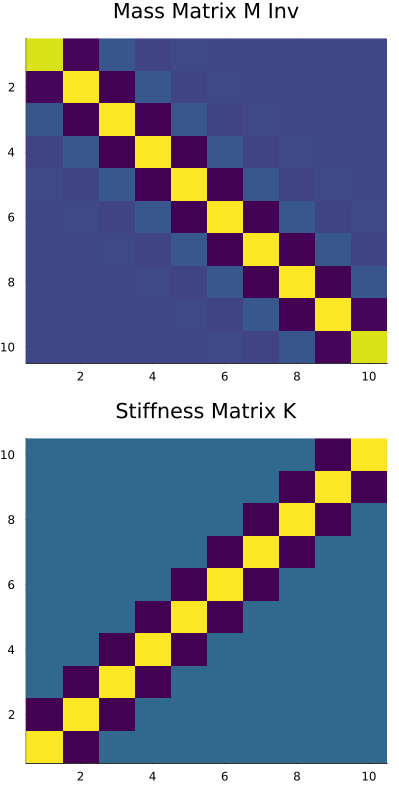

In [8]:
using LinearAlgebra
using Plots

# Basic parameters
vs = 1000    # Wave velocity [m/s] 
f = 1.0        # Central frequency of the source (in Hz)
λ = vs / f      # Wavelength

# Adjust the spatial and temporal parameters to satisfy the CFL condition
ep = 0.5     # Stability limit (0.3 is a good value for the explicit scheme)
dx = 0.01 * λ  # Spatial step size (about 1/10 of a wavelength)
dt = ep * dx / vs    # Time step size based on the CFL condition

t_max = 10.0    # Maximum simulation time (in seconds)
x_max = 100.0    # Maximum spatial coordinate (in meters) nanti jadi 10 km

println("Spatial step size: $dx")
println("Time step size: $dt")

nt = round(Int, t_max / dt) # Calculate the number of time steps based on t_max
nx = round(Int, x_max / dx) # Calculate the number of spatial steps based on x_max
println("Number of time steps: $nt")
println("Number of spatial steps: $nx")

# Initialize the spatial coordinates
x = range(0, stop=nx - 1) * dx   # initialize space coordinates
x = transpose(x)
h = diff(vec(x))                    # calculate the element sizes)

# parameters physical
ro0 = 1000    # Density [kg/m^3]
ro = x * 0 .+ ro0          # initialize density array
young_mod = x * 0 .+ ro .* vs .^ 2   # calculate young modulus from density and velocity

# initialize time axis
t = range(dt, stop=nt * dt, length=nt)

u = zeros(nx)
uold = zeros(nx)
unew = zeros(nx)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f, tau=2.0)
    A = (1 - 2 * π^2 * f^2 * (t - tau)^2)
    wavelet = A * exp(-π^2 * f^2 * (t - tau)^2)
    return wavelet
end


function linear_basis(xi)
    return [(1 - xi) / 2, (1 + xi) / 2]
end

function jacobian(x1, x2)
    return (x2 - x1) / 2
end

function gauss_legendre_quadrature()
    # Poin dan bobot kuadratur Gauss-Legendre untuk dua poin
    points = [-1 / sqrt(3), 1 / sqrt(3)]
    weights = [1.0, 1.0]

    return points, weights
end

function mass_matrix(x1, x2, rho, A)
    A = 1.0 # Cross-sectional area for 1D bar
    points, weights = gauss_legendre_quadrature()

    M = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        basis_values = linear_basis(xi)

        for i in 1:2
            for j in 1:2
                M[i, j] += w * basis_values[i] * basis_values[j] * rho * A * jacobian(x1, x2)
            end
        end
    end

    return M
end

function stiffness_matrix(x1, x2, ym)
    points, weights = gauss_legendre_quadrature()

    basis_derivatives = [-1 / 2, 1 / 2]  # Derivatives of linear basis functions

    K = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        for i in 1:2
            for j in 1:2

                dN_dx = basis_derivatives[i] / jacobian(x1, x2)

                K[i, j] += w * ym * basis_derivatives[i] * basis_derivatives[j] / jacobian(x1, x2)
            end
        end
    end

    return K
end

# make mass matrix
mass_matrices = zeros(nx, nx)

# Interior elements
for i in 2:nx-1
    mass_matrices[i:i+1, i:i+1] += mass_matrix(x[i-1], x[i], ro[i-1], h[i-1])
end

# Corner elements
mass_matrices[1:2, 1:2] += mass_matrix(x[1], x[2], ro[1], h[1])
mass_matrices[1, 1] += mass_matrix(x[1], x[2], ro[1], h[1])[1, 1]
mass_matrices[nx, nx] += mass_matrix(x[nx-1], x[nx], ro[nx-1], h[nx-1])[2, 2]

# Invert M
mass_matrices = transpose(mass_matrices)
mass_matrices_inv = inv(mass_matrices)

# heatmap(mass_matrices_inv, title="Mass Matrix M", color=:viridis, legend=false)


# Make stiffness matrix
stiffness_matrices = zeros(nx, nx)

for i in 2:nx-1
    stiffness_matrices[i:i+1, i:i+1] += stiffness_matrix(x[i-1], x[i], young_mod[i])
end

# Corner elements
stiffness_matrices[1:2, 1:2] += stiffness_matrix(x[1], x[2], young_mod[1])
stiffness_matrices[1, 1] += stiffness_matrix(x[1], x[2], young_mod[1])[1, 1]
stiffness_matrices[nx, nx] += stiffness_matrix(x[nx-1], x[nx], young_mod[nx-1])[2, 2]

stiffness_matrices = transpose(stiffness_matrices)

# Plot stiffness matrix
# heatmap(stiffness_matrices, title="Stiffness Matrix K", color=:viridis, legend=false)

# do time stepping
u_time = zeros(nt, nx)

for it in 1:nt
    unew = (dt^2) * mass_matrices_inv * (stiffness_matrices * u) + 2*u - uold     
    
    # Source term (explosion)
    unew[round(Int, nx/2)] += ricker_wavelet(t[it], 1.0)

    uold, u = u, unew

    u_time[it, :] = u
    # if it % 10 == 0
    #     IJulia.clear_output(true)
    #     p = plot(u, legend=false, title="time: $(it*dt) s")
        # plot!(x, p, color=:red, linewidth=1.5)
        # title!("Solution at t = $(it*dt)")
    #     display(p)
    # end

end

# Plot mass matrix and stiffness matrix in one plot
plot(
    heatmap(mass_matrices_inv, title="Mass Matrix M Inv", color=:viridis, legend=false, yflip=true),

    heatmap(stiffness_matrices, title="Stiffness Matrix K", color=:viridis, legend=false),
    layout=(2, 1), size=(400, 800)
    
)

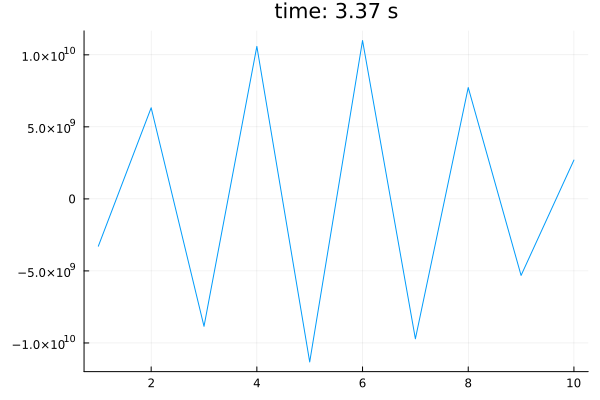

In [9]:
max_u = maximum(u_time)
min_u = minimum(u_time)

# println(u_time[nt, :])

# display
for it in 1:nt
    #     # if it % iplot == 0
    IJulia.clear_output(true)
    p = plot(u_time[it, :], legend=false, title="time: $(it*dt) s",#=  ylims=(1e-5, 1e10) =#)
            # title!("Solution at t = $(it*dt)")
    display(p)
    #     # end

    # break if u too large
    if maximum(u_time[it, :]) > 1e10
        break
    end
end